In [2]:

!pip install -U git+https://github.com/albumentations-team/albumentations;
!pip install timm;
!pip install --upgrade opencv-contrib-python;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l342xwbe
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l342xwbe
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 12.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 6.07 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

In [6]:
FILE_DIR = '/content/object-localization-dataset/train.csv'
DIR = '/content/object-localization-dataset/'
IMG_SIZE = 140
LR = 0.001
BATCH_SIZE = 16
NAME = 'efficientnet_b0'
EPOCH = 40
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
df = pd.read_csv(FILE_DIR)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


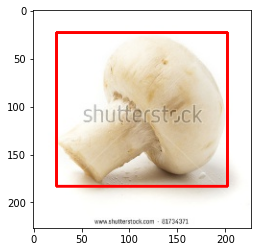

In [8]:
row = df.iloc[0,:]
image = cv2.imread(DIR + row.img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt1 = [row.xmin, row.ymin]
pt2 = [row.xmax, row.ymax]
image = cv2.rectangle(image, pt1, pt2, [255, 0 , 0], 2)
plt.imshow(image)

In [9]:
import albumentations as A


In [10]:
from albumentations.core.bbox_utils import BboxParams
from albumentations.augmentations.geometric.resize import Resize
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()], bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_params']))

validation_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE)], bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_params']))

In [11]:
train_augs(image = image, bboxes=[[row.xmin, row.ymin, row.xmax, row.ymax]], class_params= [None] )

{'bboxes': [(14.801762114537445,
   14.185022026431717,
   124.58149779735683,
   112.86343612334802)],
 'class_params': [None],
 'image': array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [2

In [12]:
train_df, validation_df = train_test_split(df, test_size=0.2, shuffle = True)

In [13]:
class ObjLocData(torch.utils.data.Dataset):
  def __init__(self, data, augmentations =  None):
    self.data = data
    self.augmentations = augmentations

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    row = df.iloc[index,:]
    image = cv2.imread(DIR + row.img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bbox = [[row.xmin, row.ymin, row.xmax, row.ymax]]

    if self.augmentations:
      datawithaugs = self.augmentations(image = image, bboxes = bbox, class_params = [None])
      image = datawithaugs['image']
      bbox = datawithaugs['bboxes'] 
      image = torch.from_numpy(image).permute(2,0,1)/255
      bbox = torch.Tensor(bbox[0])
    return image, bbox



In [14]:
train_data1 = ObjLocData(train_df, augmentations =  train_augs)
validation_data1 = ObjLocData(validation_df, augmentations =  validation_augs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


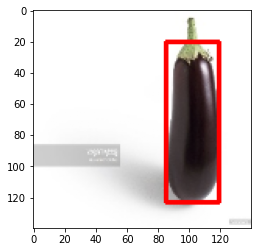

In [15]:
test_image, tes_box = train_data1[1]
xmin, ymin, xmax, ymax = tes_box

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(test_image.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

In [16]:
training_set = torch.utils.data.DataLoader(train_data1, batch_size=BATCH_SIZE, shuffle = True )
validation_set = torch.utils.data.DataLoader(validation_data1, batch_size=BATCH_SIZE, shuffle = True)

In [17]:
import timm

In [18]:
class ObjLocModel(torch.nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(NAME,pretrained=True, num_classes = 4)

  def forward(self, imgs):
    logits = self.backbone(imgs)
    return logits

model = ObjLocModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [19]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [29]:
def training_fn(loaded_data, optimizer, criterion):
  
  model.train()
  loss_total = 0.0
  
  for data in tqdm(loaded_data):
    
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    logits = model.forward(images)
    loss_ind = criterion(logits, gt_bboxes)
    optimizer.zero_grad()
    loss_ind.backward()
    optimizer.step()
    loss_total += loss_ind.item()
  
  return loss_total/len(loaded_data)

In [30]:
def validation_fn(loaded_data, criterion):
  
  model.eval()
  loss_total = 0.0
  
  for data in tqdm(loaded_data):
    
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    with torch.no_grad():
      logits = model.forward(images)
      loss_ind = criterion(logits, gt_bboxes)
      loss_total += loss_ind.item()
  
  return loss_total/len(loaded_data)

In [ ]:
validation_fn(loaded_data = validation_set,  criterion=criterion)

In [ ]:
training_fn(loaded_data = training_set, optimizer=optimizer, criterion=criterion)

In [31]:
#Final Step
best_valid_loss = np.Inf
for epoch in range(EPOCH):
  train_loss = training_fn(loaded_data = training_set, optimizer=optimizer, criterion=criterion)
  valid_loss = validation_fn(loaded_data = validation_set,  criterion=criterion)

  if valid_loss < best_valid_loss:
     torch.save(model.state_dict(), 'best_model.pt')
     print('Weights have been save HURAAAAY')
     best_valid_loss = valid_loss 

  print(f'Epoch: {epoch+1}  train loss: {train_loss}  vali loss: {valid_loss}')  

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 1  train loss: 3870.8225830078127  vali loss: 297451226.1933594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 2  train loss: 957.6291137695313  vali loss: 211285.37141927084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 3  train loss: 310.41602935791013  vali loss: 3750.7685546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 4  train loss: 195.65718994140624  vali loss: 2133.1597493489585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 5  train loss: 147.52381744384766  vali loss: 332.4502461751302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 6  train loss: 147.67215805053712  vali loss: 189.3657480875651


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7  train loss: 165.7022277832031  vali loss: 215.89339701334634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 8  train loss: 132.2714714050293  vali loss: 118.39748891194661


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9  train loss: 125.01351470947266  vali loss: 120.27084859212239


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10  train loss: 108.73791427612305  vali loss: 119.97296905517578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11  train loss: 111.11006965637208  vali loss: 174.47381083170572


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 12  train loss: 106.33117752075195  vali loss: 109.3192138671875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13  train loss: 97.48965835571289  vali loss: 110.56618754069011


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 14  train loss: 96.76734085083008  vali loss: 86.04474131266277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 15  train loss: 89.27022781372071  vali loss: 79.05744298299153


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16  train loss: 90.04165191650391  vali loss: 108.93295542399089


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17  train loss: 99.26266098022461  vali loss: 83.75771840413411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18  train loss: 92.41468048095703  vali loss: 83.05424245198567


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19  train loss: 68.98383979797363  vali loss: 103.67522430419922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20  train loss: 69.61114234924317  vali loss: 81.01953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 21  train loss: 67.41581268310547  vali loss: 62.35115178426107


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 22  train loss: 71.81640434265137  vali loss: 57.03277587890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23  train loss: 70.15838584899902  vali loss: 61.71093241373698


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24  train loss: 63.79155292510986  vali loss: 57.976662953694664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 25  train loss: 69.11720581054688  vali loss: 29.444108963012695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26  train loss: 78.99579124450683  vali loss: 41.95647048950195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27  train loss: 69.9736515045166  vali loss: 46.15881474812826


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 28  train loss: 53.91896476745605  vali loss: 20.610174496968586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29  train loss: 51.58364334106445  vali loss: 22.704421361287434


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30  train loss: 69.32515907287598  vali loss: 25.189231872558594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31  train loss: 58.20889472961426  vali loss: 21.038955688476562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32  train loss: 39.22434902191162  vali loss: 31.105304718017578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33  train loss: 56.4865234375  vali loss: 24.439058303833008


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34  train loss: 47.70871906280517  vali loss: 22.69519869486491


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 35  train loss: 49.443861389160155  vali loss: 17.307863235473633


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36  train loss: 51.2207389831543  vali loss: 19.56909243265788


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 37  train loss: 43.19490785598755  vali loss: 13.890239397684732


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights have been save HURAAAAY
Epoch: 38  train loss: 53.982937812805176  vali loss: 13.359024047851562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39  train loss: 52.690494537353516  vali loss: 19.638237635294598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40  train loss: 66.81121444702148  vali loss: 30.000478108723957


In [23]:
import utils

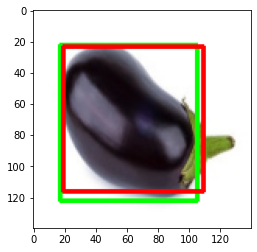

In [33]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validation_data1[12]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)